In [1]:
## Import base libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd
import GPy

In [2]:
## List of functions for GPR ##
## ============================ ##
from GPy.core.parameterization.priors import Prior
import weakref
class KDEPrior(Prior):
    _instances = []

    def __new__(cls, samples):  # Singleton:
#         if cls._instances:
#             cls._instances[:] = [instance for instance in cls._instances if instance()]
#             for instance in cls._instances:
#                 if instance().samples == samples:
#                     return instance()
        newfunc = super(Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)
        else:
            o = newfunc(cls, samples)
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()

    def __init__(self, samples):
        self.samples = samples
        self.kde = gaussian_kde(self.samples)

    def __str__(self):
        return "KDE"

    def lnpdf(self, x):
        return np.log(self.kde.pdf(x))

    def lnpdf_grad(self, x):
        # Approximate the gradient by calculating the difference in the log PDF at two close points
        epsilon = 1e-8
        log_pdf_grad = (np.log(self.kde.pdf(x + epsilon)) - np.log(self.kde.pdf(x - epsilon))) / (2 * epsilon)
        return log_pdf_grad

    def rvs(self, n=None):
        # Generate random samples from the KDE-based prior
        return self.kde.resample(size=n).flatten()


#Xtest that returns largest predictive std is
def find_Xtest(m, X, y, dim):
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest_og = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest_og.shape = (n x dim)

    
    mu, std = m.predict_noiseless(Xnew = Xtest_og, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    Xtest_maxstd = Xtest_og[np.argmax(std)].reshape(-1,dim)
    return Xtest_maxstd    


def multistart(m, n_starts = 50, optimizer = "lbfgs", noise = 0.00001, fixed_noise = True):
    '''
    Optimizer methods: 'scg','lbfgs','org-bfgs','fmin_tnc','adam'
    '''
    #Number of optimization starts
    best_model = None
    best_log_likelihood = -np.inf
    
    ## Perform multistart optimization
    for i in range(n_starts):
        # Randomly initialize the kernel parameters
        m.randomize()
        
        # Optimize the model
        m.optimize(optimizer = optimizer)
        
        # Keep track of the best model based on log likelihood
        if m.log_likelihood() > best_log_likelihood:
            best_log_likelihood = m.log_likelihood()
            best_model = m.copy()  # Store the best model
    m = best_model
    return m


#global error:
def global_error(m, X, y, dim, n = 200):
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)

    ytest = (f(Xtest) + np.random.normal(0,0,len(Xtest))).reshape(-1,1) #observations (following true unknown function we wish to approx)
    
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)

    rmse = np.sqrt(np.mean(np.array([mui - ytesti for mui, ytesti in zip(mu, ytest)])**2)) #predictions - targets
    return rmse
    

#local error (max error)
def local_error(m, X, y, dim, n=200):
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)

    ytest = (f(Xtest) + np.random.normal(0,0,len(Xtest))).reshape(-1,1) #observations (following true unknown function we wish to approx)

    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    
    localerror = np.max(np.abs(np.array([mui - ytesti for mui, ytesti in zip(mu, ytest)])))
    return localerror


#max std
def max_std(m, X, dim, n = 200):
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)
    
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    std = np.sqrt(np.abs(std))[:,0]
    max_std = np.max(std)
    return max_std


def grid_l_var(m, X, y, metric = "loglike", n = 200):
    '''
    metric = "loglike", "rmse", "maxerror", "maxstd"
    '''
    n = 200
    l_list = np.linspace(0.1, 10, n)
    sigma_list = np.linspace(0.1,20,n)
    z_list = []
    i = 0
    if metric == "loglike":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(m.log_likelihood())
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "rmse":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(global_error(m, X, y))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "maxerror":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(local_error(m, X, y))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    elif metric == "maxstd":
        for li in l_list:
            m.kern.lengthscale = li
            z_sigma = []
            for sigmai in sigma_list:
                m.kern.variance = sigmai
                z_sigma.append(max_std(m, X))
            z_list.append(np.array(z_sigma))
            i = i+1
            print(i/n,end="\r")
        z_list = np.array(z_list)
    else:
        raise Exception("Not valid metric") 
        

    l_min_id = np.unravel_index(np.nanargmax(z_list), z_list.shape)[0]
    sigma_min_id = np.unravel_index(np.nanargmax(z_list), z_list.shape)[1]
    l_min, sigma_min = l_list[l_min_id], sigma_list[sigma_min_id]
    print("lmax, sigmamax = ", l_min, sigma_min)
    return l_list, sigma_list, z_list


## List of functions for 1D GPR ##
## ============================ ##
#generate points that aren't too close to each other
def generate_points(minX, maxX, N, min_distance = 0.05, dim = 1):
    if min_distance == 0.05:
        min_distance = np.abs(maxX-minX)/(2*N)
        print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(-5, 5, size=(2,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.linalg.norm(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    #print(np.concatenate(points))
    return np.concatenate(points)


#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    #print(ysmall)
    ysmall_x = X[ysmall_i]
    #print(ysmall_x)
    wavelength = np.abs(ymax_x - ysmall_x)
    #print(wavelength)
    return wavelength[0]


def rbf_init_par(X,y):
    init_sigma_n = 0#0.0001 #np.std(y) # guess for observation noise
    init_len_scale = wavelength(X,y)
    init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations
    init_par = [init_sigma_n, init_len_scale, init_sigma_f]
    return init_par
    

#plot the posterior distribution of GPR (GPy version)
def GPy_plot_post(m, X, y):
    '''
    Plot the posterior distribution of GPR
    '''
    N = len(X)
    n = 200 # number of test points X*
    Xtest = np.linspace(min(X), max(X), n).reshape(-1,1)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest[:,0], mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()
    
    
## List of functions for 2D GPR ##
## ============================ ##
def GPy_plot_2D(m, X, y):
    dim = 2
    
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)
    
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    
    ##Render plots
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Plot predictive mean
    gx1, gx2 = g[0], g[1]
    
    #Render plots
    surf = ax.plot_surface(gx1, gx2, mu.reshape(gx1.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha = 0.3)
    
    #Plot training data
    ax.scatter(X[:,0], X[:,1], y, c = y, marker = 'o', cmap=cm.coolwarm)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

## 2D Problem

Create dataset with 2D feature space:

Text(0.5, 0.5, 'X2')

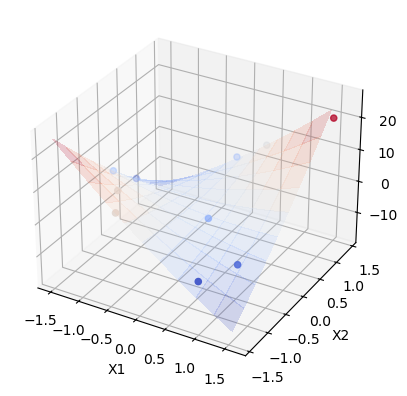

In [66]:
from sklearn.preprocessing import StandardScaler

# This is the true unknown function we are trying to approximate
f = lambda x: (x[:,0])**2 + x[:,1]**2 + 10*(x[:,0])*(x[:,1])

#This is our dataset
N = 10 #must be even
D = 2 #dimension
X = generate_points(-4, 4, N/2, min_distance = 3, dim = D)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = (f(X) + np.random.normal(0,0,N)).reshape(-1,1) #observations (following true unknown function we wish to approx)


## 2D implementation only: ##
X1 = X[:,0]
X2 = X[:,1]
f_2d = lambda x, y: f(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
#X mesh grid for plotting purposes
rx1, rx2 = np.arange(np.min(X1), np.max(X1), 0.3), np.arange(np.min(X2), np.max(X2), 0.3)
gx1, gx2 = np.meshgrid(rx1, rx2)
x = np.c_[gx1.ravel(), gx2.ravel()]

#Render plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx1, gx2, f_2d(gx1,gx2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(X1,X2,y, c = y, marker = 'o', cmap=cm.coolwarm)
ax.set_xlabel('X1')
ax.set_ylabel('X2')

---
---
## Investigating hyperparameters: $l$ and $\sigma_f$
**Approach 1: Type II maximum likelihood (we have done before, see 2_LikelihoodModelSelection)**
<br>We want to maximize the marginal log-likelihood:
$$
\ln(p(y\vert X,\theta)) = -\frac{n}{2}\ln(2\pi)-\frac{1}{2}\ln\lvert K_y\rvert-\frac{1}{2}y^TK_y^{-1} y.
$$
<br>
We can do this with a finite difference method L-BFGS-B (variation of gradient-descent method).

#### 1) Unoptimized non-ARD/ARD model:

  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                    33.69000000  |      +ve      |        
  [1]    |                    33.68000000  |      +ve      |        
  index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |               1000.00000000  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00000000  |      +ve      |        

Log-likelihood =  -11619.282001326752
RMSE =  0.004602021014916681
Max error =  0.03145310822857539
Max std =  0.003457395719056924


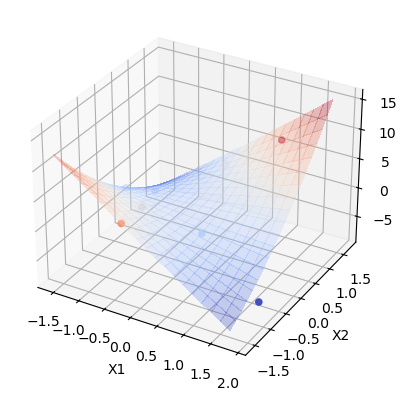

In [22]:
#Define kernel
kernel = GPy.kern.RBF(input_dim=2, variance=1000, lengthscale=[33.69,33.68], ARD = True)
#kern.variance.fix(val) if you want to fix the value of this parameter

#Construct GPR
m = GPy.models.GPRegression(X,y,kernel)
m.Gaussian_noise.variance = 0

#return the lengthscale and variance of kernel
print(m.rbf.lengthscale)
print(m.rbf.variance)
print(m.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y, D))
print("Max error = ",local_error(m, X, y, D))
print("Max std = ", max_std(m, X, D))

#Plot GPR fit on data points
GPy_plot_2D(m, X, y)

#### What is ARD?
The selection of a kernel and its parameters consitute the training of a GP. Say we have the squared exponential as our covariance function:

$$
k(x_p,x_q) = \sigma_f^2\exp\left(-\frac{1}{2}(x_p-x_q)^TM(x_p-x_q)\right) + \sigma_n^2\delta_{pq}
$$

where $\theta = (\{M\},\sigma_f^2,\sigma_n^2)^T$ is the vector of hyperparameters and Kronecker delta $\delta_{pq}$ $=1 (p=q),=0 (p\neq q)$.

Choices of $M$:
1. $M = l^{-2}I$ where we have a single choice of $l$. Corresponds to isotropic kernel. The two choices below create anisotropic kernels.
2. $M = \text{diag}(L)^{-2}$ where $L = [l_1,\ldots,l_D]$ for $D$ dimensions, so we have a lengthscale along each axis of dimension, corresponding with each of the $D$ inputs. Each $l$ is a characteristic length-scale, and if this $M$ is used in the kernel, the kernel implements automatic relevance determination (ARD), as the inverse of each length-scale determines how relevant each feature is. If $l_i$ is very large, the kernel will be practically independent of the corresponding input feature.
3. $M = \Lambda\Lambda^T + \text{diag}(L)^{-2}$ where $\Lambda$ is a $D$x$k$ matrix, $k<D$. The choice of including off-diagonal terms choice is useful for high dimensional datasets. The $k$ columns of $\Lambda$ can determine directions in input space with high relevance. The parameterization of $M$ is the factor analysis distance as the "factor analysis model seeks to explain the data through a low rank plus diagonal decomposition".

<br>

Thus, automatic relevance determination ranks input features in the order of their importance. Example: decreasing order of $L$ ranks each $l_i$ from least importance to most important. Essentially, it is a feature selection technique and what makes it automatic is that the lengthscales are automatically tuned during training (optimization of fit on data) of the hyperparameters, allowing us to determine the influence of each lengthscale based on the magnitude of their values.

We now optimize the GPR with a gradient based approach.

<br><br>
Sources use:
* Rassmussen et al.

#### 2) Optimized non-ARD/ARD model:

 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log


  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                    76.57054675  |      +ve      |        
  [1]    |                    62.20076534  |      +ve      |        
  index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |          234603542.58868831  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00000000  |   +ve fixed   |        

Log-likelihood =  -26.72959636164919
RMSE =  0.005415451498258359
Max error =  0.03296295350370926
Max std =  0.014985342811937408


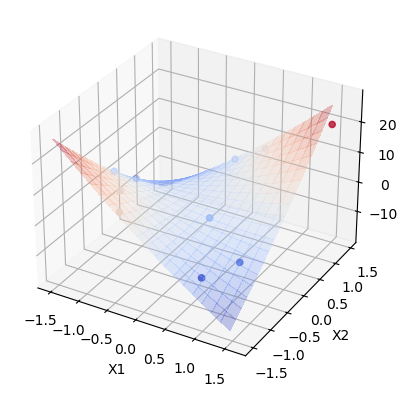

In [67]:
#Define GPR
kernel = GPy.kern.RBF(input_dim=2, variance=1, lengthscale=[10,10], ARD = True)
m = GPy.models.GPRegression(X,y,kernel)

#Constrain the parameters
# kernel.lengthscale[[0]].constrain_bounded(0.1, 100) #l1
# kernel.lengthscale[[1]].constrain_bounded(0.1, 90) #l2
#kernel.variance.constrain_bounded(0.1, 1000) #kernel.variance.constrain_positive()

#Optimize
m.Gaussian_noise.variance = 0
m.Gaussian_noise.variance.fix()
#m = multistart(m, n_starts = 50, optimizer = "lbfgs")
m.optimize()

#return the lengthscale and variance of kernel
print(m.rbf.lengthscale)
print(m.rbf.variance)
print(m.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y, D))
print("Max error = ",local_error(m, X, y, D))
print("Max std = ", max_std(m, X, D))

#Plot GPR fit on data points
GPy_plot_2D(m, X, y)

#### 3) Unoptimized off-digaonal terms model:

  index  |  GP_regression.custom_rbf.diag_terms  |  constraints  |  priors
  [0]    |                           7.00000000  |      +ve      |        
  [1]    |                           6.00000000  |      +ve      |        
  index  |  GP_regression.custom_rbf.off_diag_matrix  |  constraints  |  priors
  [0 0]  |                                0.00000000  |               |        
  [0 1]  |                                0.00100000  |               |        
  [1 0]  |                                0.00100000  |               |        
  [1 1]  |                                0.00000000  |               |        
  index  |  GP_regression.custom_rbf.variance  |  constraints  |  priors
  [0]    |                     10000.00000000  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00000000  |      +ve      |        

Log-likelihood =  -31.71761439650978
RMSE =  0.17031007944348264
Max error

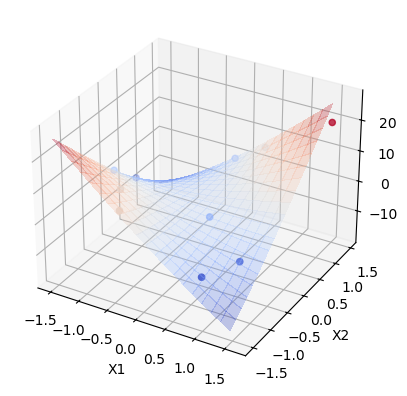

In [71]:
from GPy.kern import Kern
class CustomKernel(Kern):
    def __init__(self, input_dim, variance=1.0, diag_terms=None, off_diag_matrix=None, active_dims=None):
        super(CustomKernel, self).__init__(input_dim, active_dims, 'custom_rbf')

        # Initialize kernel parameters
        self.variance = GPy.core.Param('variance', variance)
        
        # Diagonal terms array (lengthscale-like parameters)
        if diag_terms is None:
            diag_terms = np.ones(input_dim)
        self.diag_terms = GPy.core.Param('diag_terms', diag_terms)
        
        # Off-diagonal terms matrix
        if off_diag_matrix is None:
            off_diag_matrix = np.zeros((input_dim, input_dim))
        self.off_diag_matrix = GPy.core.Param('off_diag_matrix', off_diag_matrix)
        
        # Constrain the parameters to be positive for diagonal terms
        self.link_parameters(self.variance, self.diag_terms, self.off_diag_matrix)

    # Define the custom distance metric using diagonal and off-diagonal terms
    def custom_distance(self, X, X2):
        if X2 is None:
            X2 = X
        
        kern_row = []
        for xi in X:
            kern_col = []
            for xj in X2:
                M = np.diag(1/self.diag_terms**2) + self.off_diag_matrix
                quad = np.dot((xi-xj),np.dot(M,(xi-xj).T)) #quadratic term
                kern_col.append(quad)
            kern_row.append(kern_col)
        kern_row = np.asarray(kern_row)
        return kern_row

    # Kernel function
    def K(self, X, X2=None):
        # Use the custom distance metric
        dist2 = self.custom_distance(X, X2)
        
        # Compute the RBF kernel
        return self.variance * np.exp(-0.5 * dist2)

    # Diagonal of the kernel matrix
    def Kdiag(self, X):
        return np.full(X.shape[0], self.variance)

    # Update gradients method
    def update_gradients_full(self, dL_dK, X, X2=None): #GRADIENTS ARE WRONG. DO NOT USE m.optimize()
        if X2 is None:
            X2 = X
        
        # Calculate the distances using the custom distance function
        dist2 = self.custom_distance(X, X2)
        K_matrix = self.K(X, X2)

        # Gradient with respect to variance
        dK_dvar = K_matrix / self.variance
        
        # Update the gradient for variance
        self.variance.gradient = np.sum(dK_dvar * dL_dK)
        
        # Gradient with respect to diagonal terms (diag_terms)
        cov_matrix = np.diag((1/self.diag_terms**2)) + self.off_diag_matrix
        cov_inv = np.linalg.inv(cov_matrix)

        # The gradient with respect to each diagonal term
        diff = X[:, None, :] - X2[None, :, :]
        for i in range((1/self.diag_terms**2).shape[0]):
            dK_ddiag = K_matrix * (diff[:, :, i] ** 2 * cov_inv[i, i] / self.diag_terms[i]**3)
            self.diag_terms.gradient[i] = np.sum(dK_ddiag * dL_dK)
        
        # Gradient with respect to off-diagonal terms (off_diag_matrix)
        for i in range(self.off_diag_matrix.shape[0]):
            for j in range(self.off_diag_matrix.shape[1]):
                if i != j:  # Off-diagonal terms only
                    dK_doff_diag = K_matrix * (diff[:, :, i] * diff[:, :, j] * cov_inv[i, j] / ((1/self.diag_terms**2)[i] * (1/self.diag_terms**2)[j]))
                    self.off_diag_matrix.gradient[i, j] = np.sum(dK_doff_diag * dL_dK)


# Example usage
input_dim = 2  # Number of input dimensions
variance = 10000
diag_terms = np.array([7, 6])  # Variances along each dimension
off_diag_matrix = np.array([[0, 0.001], [0.001, 0]])  # Off-diagonal terms matrix

# Instantiate the custom kernel
kernel = CustomKernel(input_dim=input_dim, variance=variance, diag_terms=diag_terms, off_diag_matrix=off_diag_matrix)
kernel.diag_terms.constrain_positive()
kernel.variance.constrain_positive()

# Create the GP model with the custom kernel
m = GPy.models.GPRegression(X, y, kernel)
m.Gaussian_noise.variance = 0

#return the lengthscale and variance of kernel
print(kernel.diag_terms)
print(kernel.off_diag_matrix)
print(kernel.variance)
print(m.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y, D))
print("Max error = ",local_error(m, X, y, D))
print("Max std = ", max_std(m, X, D))

#Plot GPR fit on data points
GPy_plot_2D(m, X, y)

#### 4) Optimized off-diagonal terms model:

In [68]:
#Define wrapper function to optimize certain params
def negative_log_like(params, X, y, noise = 0):
    variance = params[0]
    diag_terms = np.array([params[1], params[2]])  # Variances along each dimension
    off_diag_matrix = np.array([[0, params[3]], [params[3], 0]])  # Off-diagonal terms matrix
    
    # Instantiate the custom kernel
    kernel = CustomKernel(input_dim=input_dim, variance=variance, diag_terms=diag_terms, off_diag_matrix=off_diag_matrix)
    m = GPy.models.GPRegression(X, y, kernel)
    
    m.Gaussian_noise.variance = noise # (Reset the parameter first)
    if noise == 0:
        m.Gaussian_noise.variance.fix()
    obj_funct = m.log_likelihood()
    return -1*obj_funct #return negative log-likelihood

#Define Likelihood optimization method
def optimize_like(negative_log_like, params0, args, method = "L-BFGS-B"):
    bnds = ((1, 1000), (0.1, 100), (0.1, 100), (0, 1)) #put bounds = bnds
    opt_par = minimize(negative_log_like, params0, args=args, method=method, bounds = bnds, options = {'disp':True})
    print("Number of iterations = ", opt_par.nit)
    print("Min of obj funct = ", opt_par.fun)
    return opt_par.x #return optimal parameters

params0 = [1000, 0.5, 0.5, 0.001]
opt_params = optimize_like(negative_log_like, params0, args=(X,y), method="Nelder-Mead")

Optimization terminated successfully.
         Current function value: 29.707534
         Iterations: 158
         Function evaluations: 267
Number of iterations =  158
Min of obj funct =  29.707534423957306


  index  |  GP_regression.custom_rbf.diag_terms  |  constraints  |  priors
  [0]    |                           3.55867199  |      +ve      |        
  [1]    |                           2.34401082  |      +ve      |        
  index  |  GP_regression.custom_rbf.off_diag_matrix  |  constraints  |  priors
  [0 0]  |                                0.00000000  |               |        
  [0 1]  |                                0.00000000  |               |        
  [1 0]  |                                0.00000000  |               |        
  [1 1]  |                                0.00000000  |               |        
  index  |  GP_regression.custom_rbf.variance  |  constraints  |  priors
  [0]    |                      1000.00000000  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00000000  |      +ve      |        

Log-likelihood =  -29.707534423957306
RMSE =  0.7516899888605548
Max error

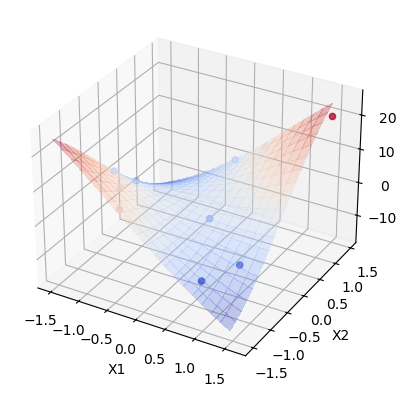

In [69]:
input_dim = 2  # Number of input dimensions
variance = opt_params[0]
diag_terms = np.array([opt_params[1], opt_params[2]])  # Variances along each dimension
off_diag_matrix = np.array([[0, opt_params[3]], [opt_params[3], 0]])  # Off-diagonal terms matrix

# Instantiate the custom kernel
kernel = CustomKernel(input_dim=input_dim, variance=variance, diag_terms=diag_terms, off_diag_matrix=off_diag_matrix)
kernel.diag_terms.constrain_positive()
kernel.variance.constrain_positive()

# Create the GP model with the custom kernel
m = GPy.models.GPRegression(X, y, kernel)
m.Gaussian_noise.variance = 0

#return the lengthscale and variance of kernel
print(kernel.diag_terms)
print(kernel.off_diag_matrix)
print(kernel.variance)
print(m.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y, D))
print("Max error = ",local_error(m, X, y, D))
print("Max std = ", max_std(m, X, D))

#Plot GPR fit on data points
GPy_plot_2D(m, X, y)

Plots of the features against the response:

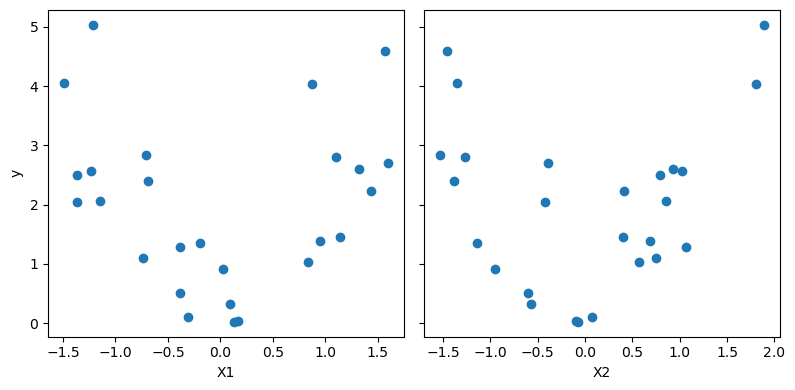

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax1.scatter(X1, y)
ax1.set_xlabel("X1")
ax1.set_ylabel("y")

ax2.scatter(X2, y)
ax2.set_xlabel("X2")

plt.tight_layout()
plt.show()

---
**Approach 2: MCMC method**
<br>
We would like to find the posterior over the hyperparameters from Bayes' rule:
$$
p(\theta\vert y,X) = \frac{p(y\vert X,\theta)p(\theta)}{p(y\vert X)}
$$
where $p(\theta)$ is the hyper-prior (prior distribution for hyperparameters) and the marginal likelihood (evidence) is
$$
p(y\vert X) = \int p(y\vert X,\theta)p(\theta) d\theta
$$
So far we've used the MCMC method Metropolis-Hastings (MH) as our sampler which wasn't the most efficient and may require a long time to converge. Hamiltonian Monte Carlo (HMC) uses first-order gradients of the log posterior rather than a random walk. The latest sampling technique is called the No-U-Turn Sampler (NUTS), an upgrade from HMC. Unlike HMC, NUTS does not require us to specify the number of steps or step size parameters, which it automatically determines through each iteration.

In [78]:
#Ensure priors are re-set
m.rbf.lengthscale.unconstrain()
m.rbf.variance.unconstrain()
m.rbf.variance.constrain_positive()

#Construct priors for your hyperparameters
gamma_prior = GPy.priors.Gamma.from_EV(5,1.1)
uniform_prior = GPy.priors.Uniform(0.001,1000)

#Set priors on the ARD lengthscales (one for each dimension)
for i in range(D):
    m.rbf.lengthscale[[i]].set_prior(uniform_prior)

#Set prior for the variance parameter
m.rbf.variance.set_prior(uniform_prior)

#return the lengthscale and variance of kernel
print(m.rbf.lengthscale)
print(m.rbf.variance)
print(m.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y, D))
print("Max error = ",local_error(m, X, y, D))
print("Max std = ", max_std(m, X, D))

reconstraining parameters GP_regression.rbf.variance


  index  |  GP_regression.rbf.lengthscale  |  constraints  |      priors    
  [0]    |                     7.35702654  |      +ve      |  [0.001, 1e+03]
  [1]    |                     7.48357527  |      +ve      |  [0.001, 1e+03]
  index  |  GP_regression.rbf.variance  |  constraints  |      priors    
  [0]    |                999.99999028  |      +ve      |  [0.001, 1e+03]
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00100000  |   +ve fixed   |        

Log-likelihood =  16.971779833066684
RMSE =  0.02386721763609185
Max error =  0.1637539965164052
Max std =  0.08639663664690471


In [79]:
#Draw 1000 samples from the GP model
hmc = GPy.inference.mcmc.HMC(m, stepsize = 5e-2)
s = hmc.sample(num_samples=1000) #Number of samples

 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:119: RuntimeWarning:overflow encountered in expm1
 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:121: RuntimeWarning:overflow encountered in expm1


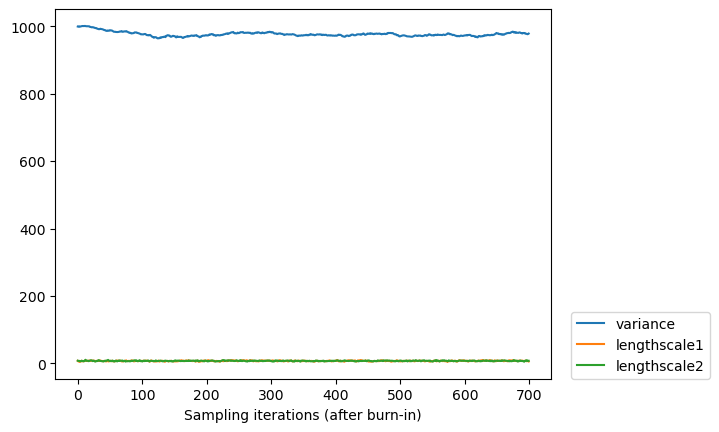

In [80]:
#Include burn-in
labels = ["variance","lengthscale1","lengthscale2"]
samples = s[300:] # cut out the burn-in period

#plot the samples
plt.xlabel("Sampling iterations (after burn-in)")
plt.plot(samples, label=labels)
plt.legend(loc=(1.04, 0))

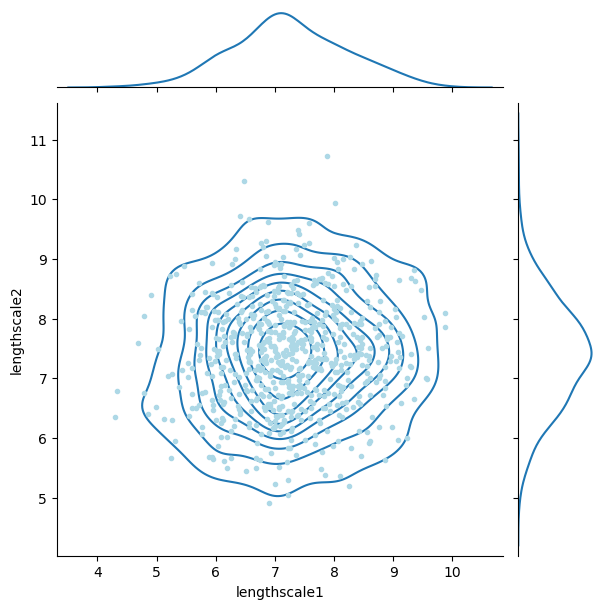

In [81]:
sns.jointplot(x=samples[:,1],y=samples[:,2], kind='kde')
plt.plot(samples[:,1], samples[:,2],'.',color="lightblue")
plt.xlabel(labels[1]); plt.ylabel(labels[2])
plt.show()

---
**Adaptive sampling**
<br>
We now add a new observation at the point of maximum variance. We use the previous posterior distributions for $l$ and $\sigma_f$ as the priors for the new posterior distributions.

Text(0.5, 0.5, 'X2')

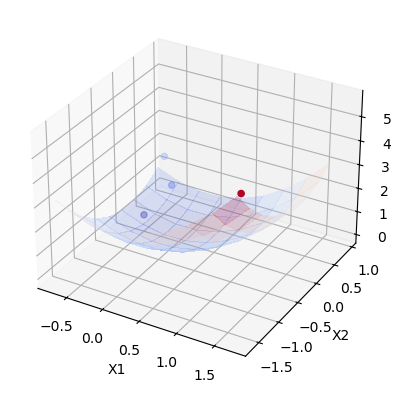

In [42]:
#Original plot
#X mesh grid for plotting purposes
rx1, rx2 = np.arange(np.min(X1), np.max(X1), 0.3), np.arange(np.min(X2), np.max(X2), 0.3)
gx1, gx2 = np.meshgrid(rx1, rx2)
x = np.c_[gx1.ravel(), gx2.ravel()]

#Render plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx1, gx2, f_2d(gx1,gx2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(X1,X2,y, c = y, marker = 'o', cmap=cm.coolwarm)
ax.set_xlabel('X1')
ax.set_ylabel('X2')

In [43]:
Xtest_maxstd = find_Xtest(m,X,y,dim=D)
Xtest_maxstd

array([[ 0.71516634, -1.63953541]])

Text(0.5, 0.5, 'X2')

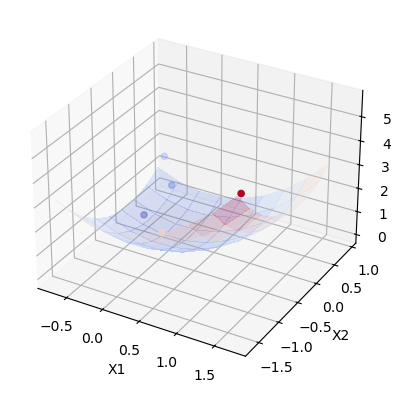

In [44]:
X_new = X
Xnew = np.append(X_new,Xtest_maxstd, axis=0)
ynew = (f(Xnew) + np.random.normal(0,0,N+1)).reshape(-1,1) #observations (following true unknown function we wish to approx)

#New plot
#X mesh grid for plotting purposes
Xnew1 = Xnew[:,0]
Xnew2 = Xnew[:,1]
rx1, rx2 = np.arange(np.min(Xnew1), np.max(Xnew1), 0.3), np.arange(np.min(Xnew2), np.max(Xnew2), 0.3)
gx1, gx2 = np.meshgrid(rx1, rx2)
xnew = np.c_[gx1.ravel(), gx2.ravel()]

#Render plots
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx1, gx2, f_2d(gx1,gx2), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(Xnew1,Xnew2,ynew, c = ynew, marker = 'o', cmap=cm.coolwarm)
ax.set_xlabel('X1')
ax.set_ylabel('X2')

In [45]:
#Ensure priors and constraints are re-set
m.rbf.lengthscale.unconstrain()
m.rbf.variance.unconstrain()
m.rbf.lengthscale.constrain_positive()
m.rbf.variance.constrain_positive()

#Construct priors for your hyperparameters
kde_prior_sigma = KDEPrior(samples[:,0])

#Set priors on the ARD lengthscales (one for each dimension)
for i in range(2):
    m.rbf.lengthscale[[i]].set_prior(KDEPrior(samples[:,i+1]))

#Set priors for variance
# m.rbf.variance.set_prior(kde_prior_sigma)

#return the lengthscale and variance of kernel
print(m.rbf.lengthscale)
print(m.rbf.variance)
print(m.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", m.log_likelihood())
print("RMSE = ", global_error(m, X, y, D))
print("Max error = ",local_error(m, X, y, D))
print("Max std = ", max_std(m, X, D))

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.42158087  |      +ve      |   KDE  
  [1]    |                    20.23473405  |      +ve      |   KDE  
  index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |                 46.95127398  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00100000  |   +ve fixed   |        

Log-likelihood =  -9.479902454979914
RMSE =  1.791090095447008
Max error =  4.166698904083424
Max std =  6.830533992735205


In [46]:
#Draw 1000 samples from the GP model
hmc = GPy.inference.mcmc.HMC(m, stepsize = 5e-2)
s = hmc.sample(num_samples=1000) #Number of samples

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


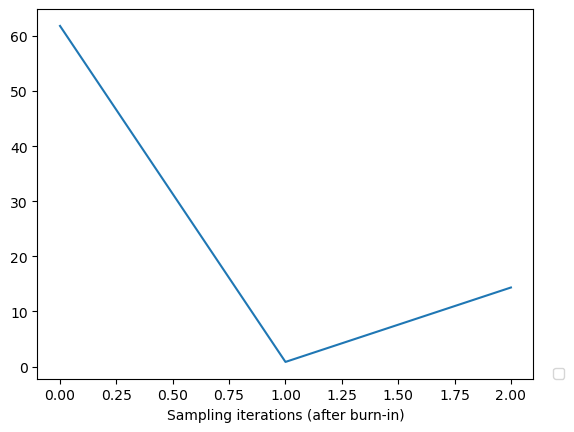

In [47]:
#Include burn-in
#labels = ["variance","lengthscale1","lengthscale2"]
samples = s[300:] # cut out the burn-in period

#plot the samples
plt.xlabel("Sampling iterations (after burn-in)")
plt.plot(samples[2,])
plt.legend(loc=(1.04, 0))

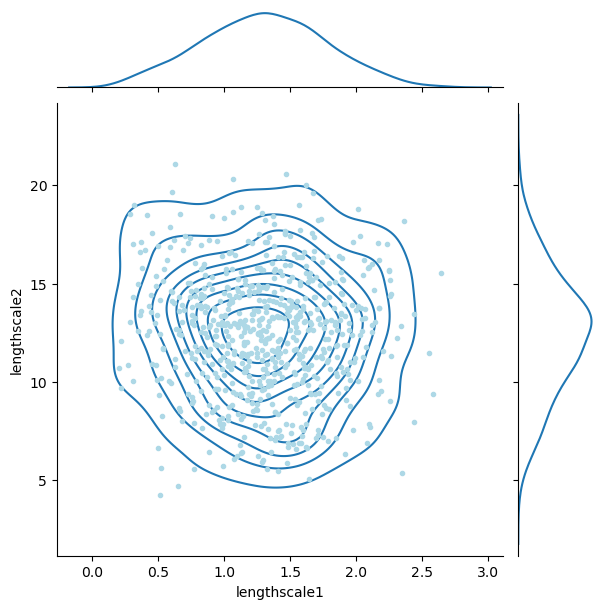

In [48]:
sns.jointplot(x=samples[:,1],y=samples[:,2], kind='kde')
plt.plot(samples[:,1], samples[:,2],'.',color="lightblue")
plt.xlabel(labels[1]); plt.ylabel(labels[2])
plt.show()